# Creating 400 models for training:

In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import os 
from tensorflow import keras
%matplotlib inline
import visualkeras
import logging
import pickle
import re
import seaborn as sns
import pandas as pd


print(tf.version.VERSION)

2.15.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
#importing my functions

from helpers_build import (build_ffnn_model,
                           build_cnn_model,
                           build_models_from_dict,
                          generate_architectures,
                          config_extract)          

from helpers_train import (train_model,
                          train_models,
                          plot_training_history)

In [4]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

# Clear any logs from previous runs
#!rm -rf /logs/

# %reload_ext tensorboard

## getting the data after extraction

In [6]:
xtest = open("chihuaha muffin data/X_test.pickle","rb")
X_test = pickle.load(xtest)

xtrain = open("chihuaha muffin data/X_train.pickle","rb")
X_train = pickle.load(xtrain)


ytest = open("chihuaha muffin data/y_test.pickle","rb")
y_test = pickle.load(ytest)

ytrain = open("chihuaha muffin data/y_train.pickle","rb")
y_train = pickle.load(ytrain)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_train[0])
print(y_train[0])

(4732, 64, 64, 1)
(4732,)
[[[0.2627451 ]
  [0.23529412]
  [0.25490196]
  ...
  [0.21568627]
  [0.22352941]
  [0.23921569]]

 [[0.34117647]
  [0.26666667]
  [0.25490196]
  ...
  [0.18039216]
  [0.19215686]
  [0.2       ]]

 [[0.38039216]
  [0.30588235]
  [0.2627451 ]
  ...
  [0.16078431]
  [0.19215686]
  [0.22352941]]

 ...

 [[0.22745098]
  [0.19215686]
  [0.23137255]
  ...
  [0.41960784]
  [0.28235294]
  [0.31764706]]

 [[0.25882353]
  [0.20784314]
  [0.19215686]
  ...
  [0.21960784]
  [0.33333333]
  [0.27058824]]

 [[0.28627451]
  [0.29019608]
  [0.24705882]
  ...
  [0.0745098 ]
  [0.23921569]
  [0.43529412]]]
0


# example use

In [ ]:
neurons_list_ffnn = [16]
input_shape_ffnn = (64, 64, 1)
dropout_rates_ffnn = [0.2]  # None means no dropout for that layer
batch_norms_ffnn = [True]  # True means batch normalization for that layer

ffnn_model = build_ffnn_model(neurons_list_ffnn, input_shape_ffnn,
                               activation='relu', output_activation='sigmoid',
                               optimizer='adam', loss='binary_crossentropy',
                               metrics=['accuracy'], dropout_rates=dropout_rates_ffnn,
                               batch_norms=batch_norms_ffnn, learning_rate=0.002)

plot_model(ffnn_model)

In [ ]:
visualkeras.layered_view(ffnn_model, legend=True, spacing=5, scale_xy=2)

In [ ]:
input_shape_cnn = (64, 64, 1)
filters_list_cnn = [32, 64, 128]
conv_dropout_rates_cnn = [None, None, None]
conv_batch_norms_cnn = [False, False, False]
neurons_list_cnn = [128]
dense_dropout_rates_cnn = [None]
dense_batch_norms_cnn = [False]

cnn_model = build_cnn_model(
    neurons_list_cnn,
    filters_list_cnn,
    input_shape_cnn,
    activation='relu',
    output_activation='sigmoid',
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
    conv_dropout_rates=conv_dropout_rates_cnn,
    conv_batch_norms=conv_batch_norms_cnn,
    dense_dropout_rates=dense_dropout_rates_cnn,
    dense_batch_norms=dense_batch_norms_cnn,
    learning_rate=0.001
)


visualkeras.layered_view(cnn_model, legend=True, spacing=5, scale_xy=2)


In [ ]:
history_1=train_model(cnn_model,
                train_data = rescaled_train_data,
                val_data = rescaled_val_data,
                batch_size = 32,
                epochs = 25)

plot_training_history(history_1)

# 400

In [7]:
all_archs_dict = generate_architectures(batchnorm=False, drop=None)
print(len(all_archs_dict))

400


In [ ]:
built_models = build_models_from_dict(all_archs_dict, input_shape_cnn=(64,64,1))

In [ ]:
built_models

In [ ]:
histories = train_models(built_models, x_train=X_train, y_train=y_train, batch_size=32, epochs=15,validation_split= 0.2)

**each history which is a dictionnary will be saved in a .pickle file in a folder and then used to get insights**

**here we are getting the dictionnaries and merging all together**

In [ ]:
# where all pickle files are stored
pickle_directory = 'histories'

all_files = os.listdir(pickle_directory)

# searching for '.pkl'
pickle_files = [file for file in all_files if file.endswith('.pkl')]

all_histories = {}

for pickle_file in pickle_files:
    model_name = os.path.splitext(pickle_file)[0]  
    file_path = os.path.join(pickle_directory, pickle_file)
    
    with open(file_path, 'rb') as file:
        history_data = pickle.load(file)
        all_histories[model_name] = history_data

# this contains the data for all models
all_histories


**now we want to get from `all_histories` the number of filters neurons and layers**

In [5]:
model_info_list = []


for model_name, history in all_histories.items():
    # extract configuration
    filters, neurones = config_extract(model_name)
    
    #average validation loss 
    avg_val_loss = np.mean(history['val_loss'])
    last_epoch_loss = history['val_loss'][1]
    
    
    model_info = {
        'model_name': model_name,
        'filters': filters,
        'neurones': neurones,
        'avg_val_loss': avg_val_loss,
        'last_val_loss': last_epoch_loss
    }
    
    model_info_list.append(model_info)

#model_info_list contains the  info for analysis and visualization


## Now we can explore the different architectures

In [6]:
# df for the number of filters
filters_df_data = {'Model': [], 'Num_Conv_Layers': [], 'Position': [], 'Num_Filters': [], 'Avg_Val_Loss': []}

for model_info in model_info_list:
    model_name = model_info['model_name']
    num_conv_layers = len(model_info['filters'])
    
    for position, num_filters in enumerate(model_info['filters']):
        filters_df_data['Model'].append(model_name)
        filters_df_data['Num_Conv_Layers'].append(num_conv_layers)
        filters_df_data['Position'].append(position + 1)
        filters_df_data['Num_Filters'].append(num_filters)
        filters_df_data['Avg_Val_Loss'].append(model_info['avg_val_loss'])

filters_df = pd.DataFrame(filters_df_data)

# dffor the number of neurons
neurons_df_data = {'Model': [], 'Num_Dense_Layers': [], 'Position': [], 'Num_Neurons': [], 'Avg_Val_Loss': []}

for model_info in model_info_list:
    model_name = model_info['model_name']
    num_dense_layers = len(model_info['neurones'])
    
    for position, num_neurons in enumerate(model_info['neurones']):
        neurons_df_data['Model'].append(model_name)
        neurons_df_data['Num_Dense_Layers'].append(num_dense_layers)
        neurons_df_data['Position'].append(position + 1)
        neurons_df_data['Num_Neurons'].append(num_neurons)
        neurons_df_data['Avg_Val_Loss'].append(model_info['avg_val_loss'])

neurons_df = pd.DataFrame(neurons_df_data)


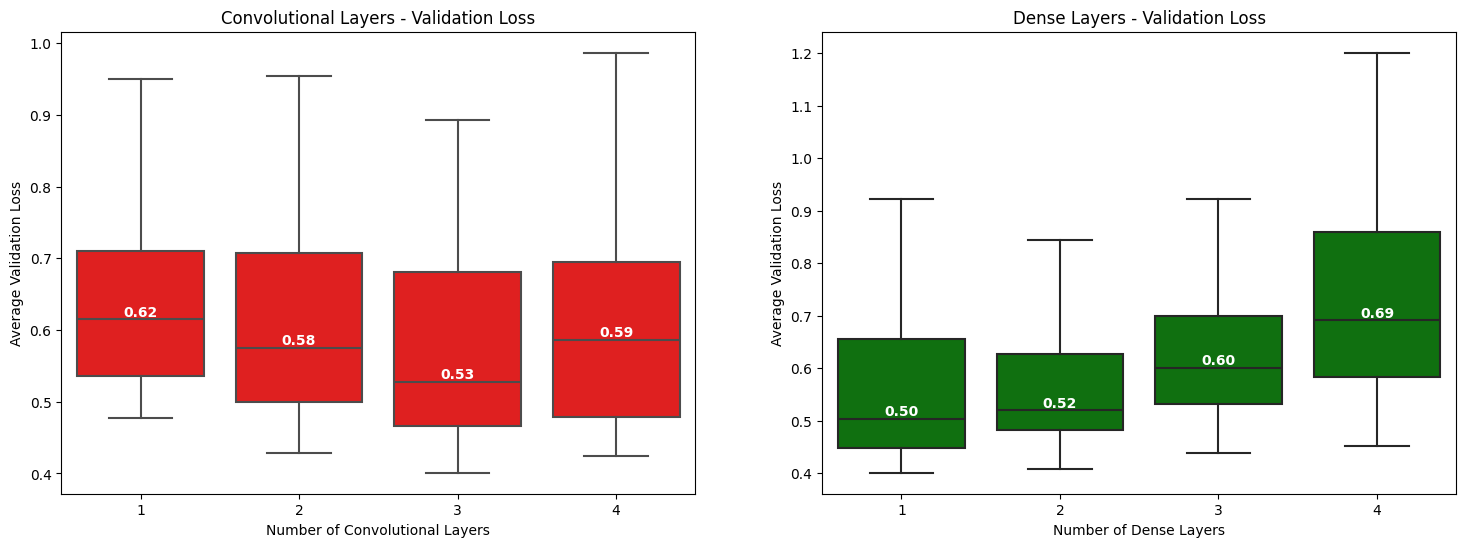

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

#Convolutional Layers
sns.boxplot(ax=axes[0],x='Num_Conv_Layers', y='Avg_Val_Loss', data=filters_df, showfliers=False, color='red')
axes[0].set_xlabel('Number of Convolutional Layers')
axes[0].set_ylabel('Average Validation Loss')
axes[0].set_title('Convolutional Layers - Validation Loss')

# to add values 
medians_conv = filters_df.groupby('Num_Conv_Layers')['Avg_Val_Loss'].median()
for i, median_value in enumerate(medians_conv):
    axes[0].text(i, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='white', fontweight='bold')

#Dense Layers
sns.boxplot(ax=axes[1],x='Num_Dense_Layers', y='Avg_Val_Loss', data=neurons_df, showfliers=False, color= 'green')
axes[1].set_xlabel('Number of Dense Layers')
axes[1].set_ylabel('Average Validation Loss')
axes[1].set_title('Dense Layers - Validation Loss')

#same as above
medians_dense = neurons_df.groupby('Num_Dense_Layers')['Avg_Val_Loss'].median()
for i, median_value in enumerate(medians_dense):
    axes[1].text(i, median_value, f'{median_value:.2f}', ha='center', va='bottom', color='white', fontweight='bold')

plt.savefig('plots/layers.png')
plt.show()


In [8]:
# For Convolutional Layers
conv_mean_val_loss = filters_df.groupby('Num_Conv_Layers')['Avg_Val_Loss'].mean()
conv_median_val_loss = filters_df.groupby('Num_Conv_Layers')['Avg_Val_Loss'].median()

# For Dense Layers
dense_mean_val_loss = neurons_df.groupby('Num_Dense_Layers')['Avg_Val_Loss'].mean()
dense_median_val_loss = neurons_df.groupby('Num_Dense_Layers')['Avg_Val_Loss'].median()

print("Convolutional Layers:")
print("Mean Validation Loss:")
print(conv_mean_val_loss)
print("\nMedian Validation Loss:")
print(conv_median_val_loss)

print("\nDense Layers:")
print("Mean Validation Loss:")
print(dense_mean_val_loss)
print("\nMedian Validation Loss:")
print(dense_median_val_loss)


Convolutional Layers:
Mean Validation Loss:
Num_Conv_Layers
1      1.110401
2      4.150721
3    142.322366
4      0.818580
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Conv_Layers
1    0.615417
2    0.575181
3    0.528137
4    0.586358
Name: Avg_Val_Loss, dtype: float64

Dense Layers:
Mean Validation Loss:
Num_Dense_Layers
1      0.638843
2      0.769702
3      3.148965
4    145.327752
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Dense_Layers
1    0.504270
2    0.520570
3    0.601216
4    0.691428
Name: Avg_Val_Loss, dtype: float64


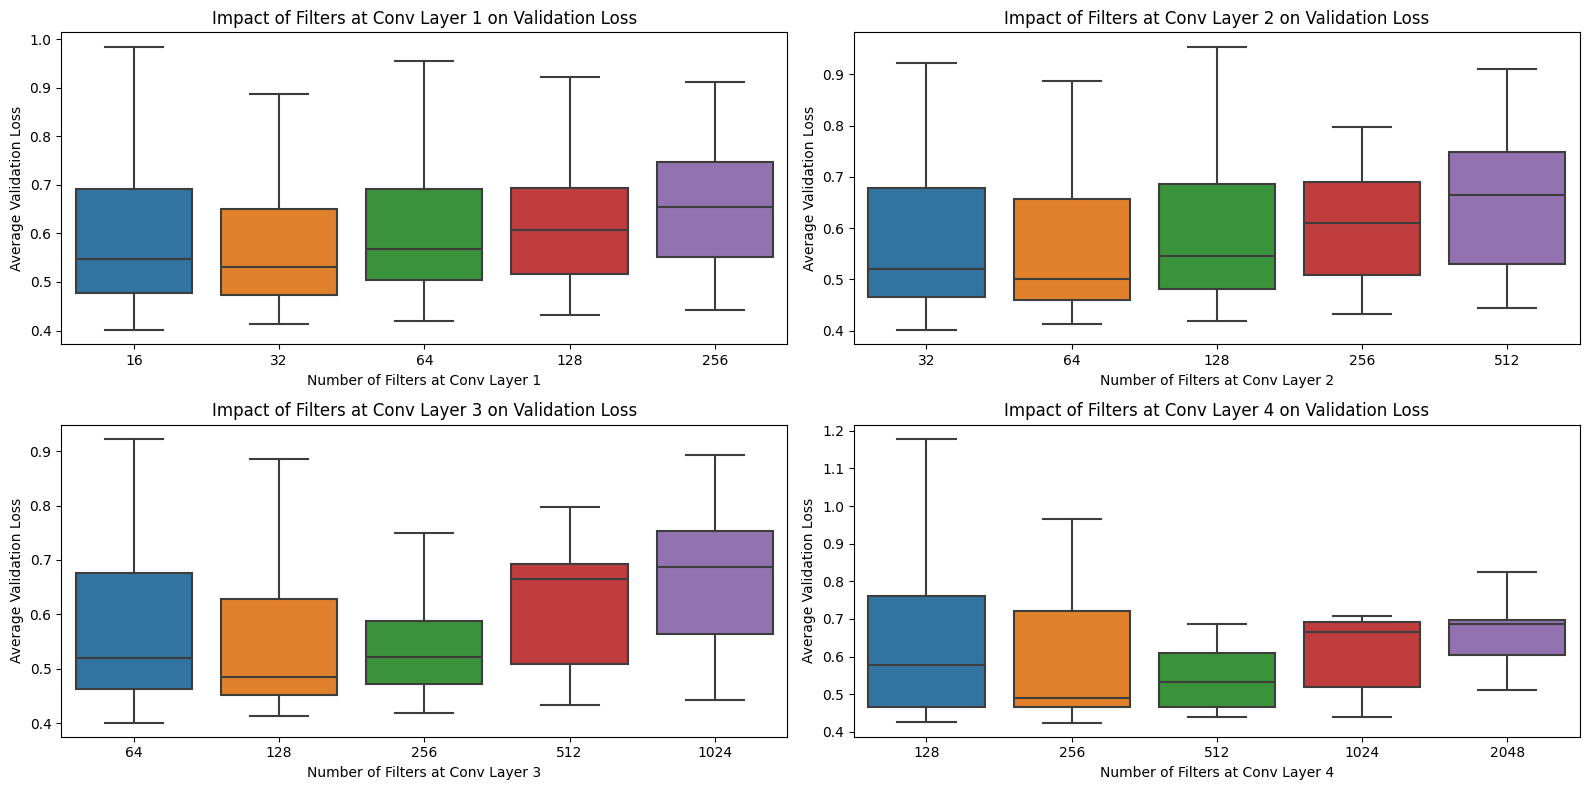

In [9]:
plt.figure(figsize=(16, 8))
for position in range(1, max(filters_df['Position']) + 1):
    plt.subplot(2, 2, position)
    sns.boxplot(x='Num_Filters', y='Avg_Val_Loss', data=filters_df[filters_df['Position'] == position], showfliers = False)
    plt.xlabel(f'Number of Filters at Conv Layer {position}')
    plt.ylabel('Average Validation Loss')
    plt.title(f'Impact of Filters at Conv Layer {position} on Validation Loss')


plt.tight_layout()
plt.show()


In [10]:
# numerical values for Convolutional Layers
for position in range(1, max(filters_df['Position']) + 1):
    filtered_data = filters_df[filters_df['Position'] == position]
    
    print(f"\nFor Convolutional Layer {position}:")
    print("Mean Validation Loss:")
    print(filtered_data.groupby('Num_Filters')['Avg_Val_Loss'].mean())
    
    print("\nMedian Validation Loss:")
    print(filtered_data.groupby('Num_Filters')['Avg_Val_Loss'].median())



For Convolutional Layer 1:
Mean Validation Loss:
Num_Filters
16       0.774015
32       3.808591
64       0.717011
128    179.082738
256      1.130128
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Filters
16     0.547119
32     0.531715
64     0.567206
128    0.607457
256    0.653458
Name: Avg_Val_Loss, dtype: float64

For Convolutional Layer 2:
Mean Validation Loss:
Num_Filters
32       0.776713
64       4.731969
128      0.637857
256    238.001500
512      1.217396
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Filters
32     0.520545
64     0.500944
128    0.545925
256    0.610574
512    0.665313
Name: Avg_Val_Loss, dtype: float64

For Convolutional Layer 3:
Mean Validation Loss:
Num_Filters
64        0.630709
128       1.326902
256       0.602241
512     353.958452
1024      1.374398
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Filters
64      0.519511
128     0.485626
256     0.522001
512     0.665794
1024    0.687492
Name: Av

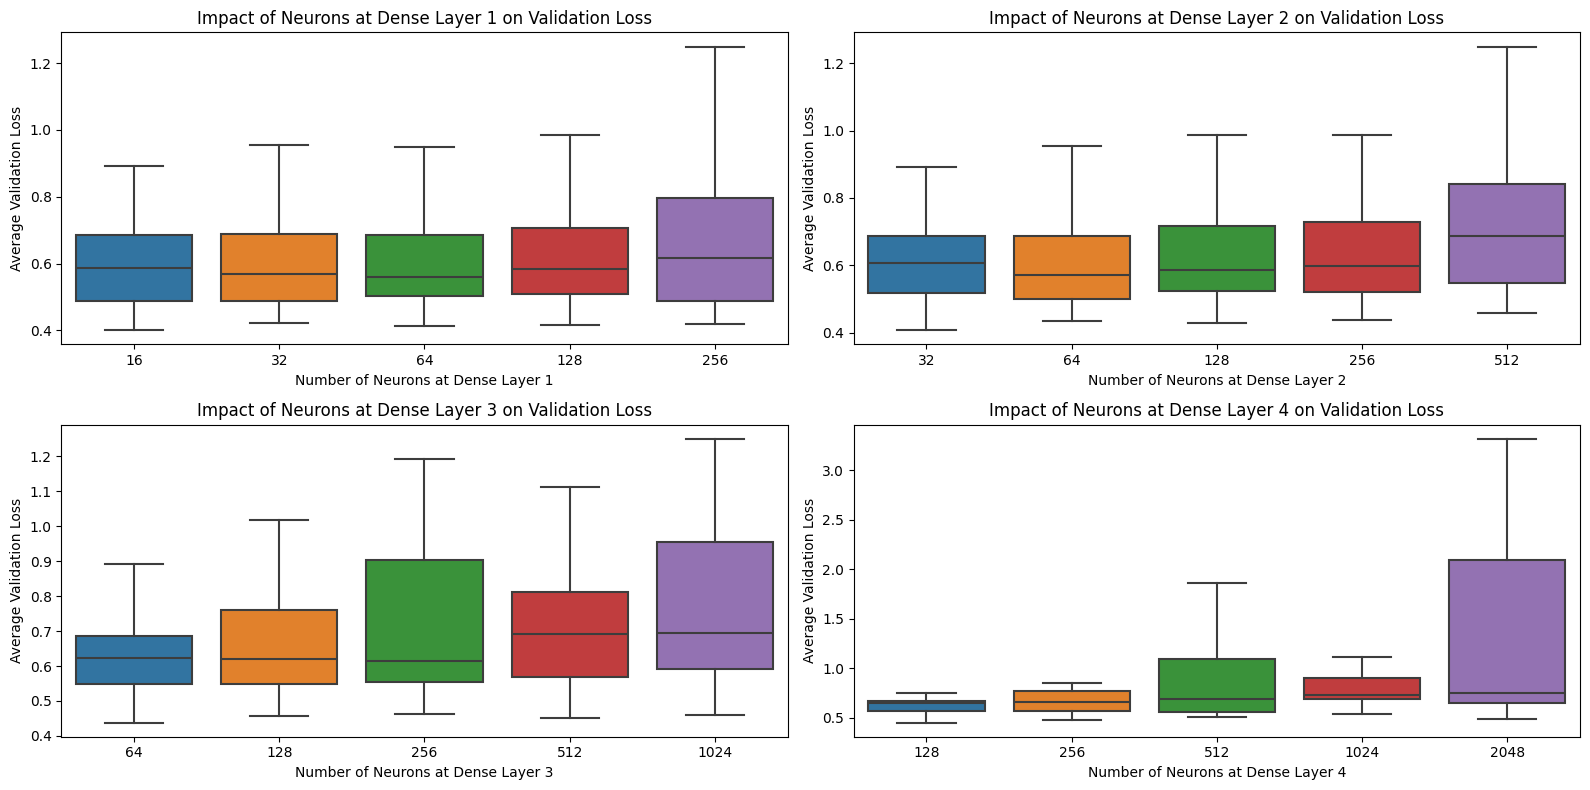

In [11]:
plt.figure(figsize=(16, 8))
for position in range(1, max(neurons_df['Position']) + 1):
    plt.subplot(2, 2, position)
    sns.boxplot(x='Num_Neurons', y='Avg_Val_Loss', data=neurons_df[neurons_df['Position'] == position], showfliers = False)
    plt.xlabel(f'Number of Neurons at Dense Layer {position}')
    plt.ylabel('Average Validation Loss')
    plt.title(f'Impact of Neurons at Dense Layer {position} on Validation Loss')

plt.tight_layout()
plt.show()


In [12]:
# numerical values for Dense Layers
for position in range(1, max(neurons_df['Position']) + 1):
    filtered_data = neurons_df[neurons_df['Position'] == position]
    
    print(f"\nFor Dense Layer {position}:")
    print("Mean Validation Loss:")
    print(filtered_data.groupby('Num_Neurons')['Avg_Val_Loss'].mean())
    
    print("\nMedian Validation Loss:")
    print(filtered_data.groupby('Num_Neurons')['Avg_Val_Loss'].median())



For Dense Layer 1:
Mean Validation Loss:
Num_Neurons
16       0.925085
32       2.165772
64       3.787005
128      0.798333
256    177.646728
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Neurons
16     0.587209
32     0.568974
64     0.560385
128    0.583067
256    0.616915
Name: Avg_Val_Loss, dtype: float64

For Dense Layer 2:
Mean Validation Loss:
Num_Neurons
32       0.977610
64       2.742342
128      5.027056
256      0.881084
512    249.082631
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Neurons
32     0.605435
64     0.571898
128    0.586907
256    0.597211
512    0.687028
Name: Avg_Val_Loss, dtype: float64

For Dense Layer 3:
Mean Validation Loss:
Num_Neurons
64        0.725101
128       3.852981
256       7.231820
512       1.047533
1024    373.286778
Name: Avg_Val_Loss, dtype: float64

Median Validation Loss:
Num_Neurons
64      0.624176
128     0.618856
256     0.613693
512     0.692537
1024    0.694282
Name: Avg_Val_Loss, dtype: float